# Automatic bibliography map generation

Don't forget to write a brief summary of this notebook

## Initialize notebook, perform a search and save it in a local file

First we initialize the interactive plotting (will be needed later)

In [1]:
%matplotlib notebook

We need to put together a query string. Here we specify a search phrase and (optionally) date filters, sorting and the amount of results to return. The instructions about how to write a query string are described [here](https://dev.elsevier.com/tecdoc_federated_search.html).

In [2]:
query = ['PUBYEAR > 1989 AND PUBYEAR < 2017 AND TITLE-ABS-KEY(Masonry+Earthquake)']
query.append("view=COMPLETE")
query.append("count=25")  # Our subscription allows up to 25 results at a time

I keep my private API key out of this public repository. You should create your own [configuration file as described here](https://github.com/ElsevierDev/elsapy/blob/master/CONFIG.md)

In [3]:
import json
with open("config.json") as con_file:
    config = json.load(con_file)

The following initializes the client and the doc_search object, and then executes the search.

In [5]:
from elsapy.elsclient import ElsClient
from elsapy.elssearch import ElsSearch
client = ElsClient(config['apikey'])
doc_srch = ElsSearch('&'.join(query), 'scopus')
doc_srch.execute(client, get_all=True)

Save a .json file with the search results(human-readable)

In [6]:
filename = "my_results.json"
with open("output/{}".format(filename), 'w') as json_file:
    json.dump(doc_srch.results, json_file)
print('Done saving {0} results to file "{1}".'.format(len(doc_srch.results), filename))

Done saving 2988 results to file "my_results.json".


## Clean up the raw data and remove invalid records

This section will depend on the data you obtain.
Our data set here requires very little cleaning, but it is useful as an example.
First we retrieve the results from the file we just created and import them into a Pandas DataFrame

In [7]:
import pandas.io.json
filename = "my_results.json"
with open("output/{}".format(filename), 'r') as results_file:
    results = json.load(results_file)
df_results = pandas.io.json.json_normalize(results)
print('Loaded {0} results from file "{1}".'.format(len(results), filename))

Loaded 2988 results from file "my_results.json".


Some records are "conference reviews", not articles, and are therefore not relevant.

In [8]:
conference_review = df_results[df_results['subtype'] == "cr"].index
df_results.drop(conference_review, inplace=True)
print("Removed {0} 'Conference Review' records.".format(len(conference_review)))

Removed 51 'Conference Review' records.


A couple of records have no author data or title. We need to remove those as well.

In [9]:
no_author_data = df_results[df_results['author'].isnull()].index
df_results.drop(no_author_data, inplace=True)
print("Removed {0} records missing author data.".format(len(no_author_data)))

no_title = df_results[df_results['dc:title'].isnull()].index
df_results.drop(no_title, inplace=True)
print("Removed {0} records with no title:".format(len(no_title)))
number_of_papers = len(df_results.index)

print("Proceeding with the remaining ({0}) records".format(number_of_papers))

Removed 10 records missing author data.
Removed 0 records with no title:
Proceeding with the remaining (2927) records


After removing the invalid records, it is convenient to create a new DataFrame containing only the fields (columns) we are interested in visualizing.

In [10]:
import pandas as pd
from helperfuncs import extract_auth, extract_keywords, count_items
rec_date = pd.to_datetime(df_results['prism:coverDate'])
rec_auth = df_results['author'].map(extract_auth)
rec_kw = df_results['authkeywords'].map(extract_keywords)
rec_title = df_results['dc:title']
dict_of_series = {"Author": rec_auth,
                  "Date": rec_date,
                  "Keywords": rec_kw,
                  "Num_of_keywords": rec_kw.map(count_items),
                  "Title": rec_title,
                  "Year": rec_date.map(lambda x: x.year)}
df = pd.DataFrame(dict_of_series)

## Generate the visualizations

All the following plots will use matplotlib.
Using Seaborn is optional, but the plots look (subjectively) better.

In [11]:
import matplotlib.pyplot as plt
# import seaborn; seaborn.set()  # set plot style

Figure 1 shows the amount of papers (and related keywors) per year.

<IPython.core.display.Javascript object>


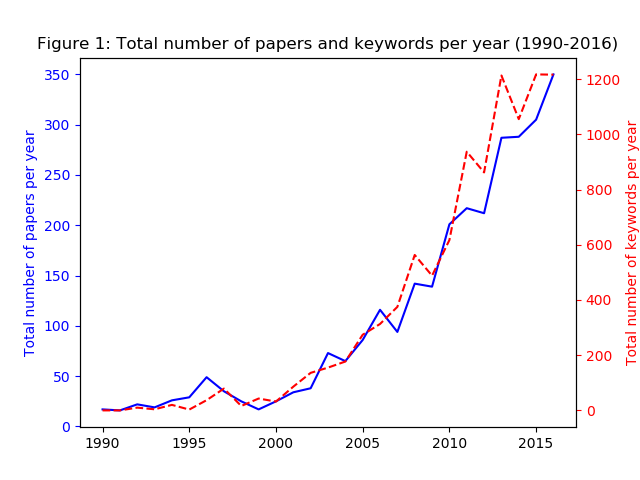

In [12]:
papers_per_year = df['Year'].value_counts().sort_index()
keywords_per_year = df.groupby("Year")["Num_of_keywords"].sum()
fig02 = plt.figure()
ax02 = fig02.add_subplot(1, 1, 1)
ax02.set_title("Figure 1: Total number of papers and keywords per year (1990-2016)")
ax02.plot(papers_per_year, 'b-')
ax02.set_ylabel('Total number of papers per year', color='b')
ax02.tick_params('y', colors='b')

ax02b = ax02.twinx()
ax02b.plot(keywords_per_year, 'r--')
ax02b.set_ylabel('Total number of keywords per year', color='r')
ax02b.tick_params('y', colors='r')


### Keyword analysis

Figure 2 shows the relation between the two plots in Figure 1, namely the number of keywords per paper, per year.

<IPython.core.display.Javascript object>


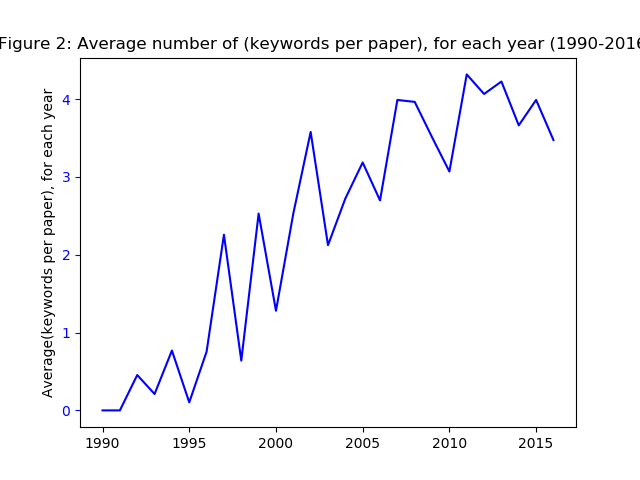

In [13]:
keywords_per_paper = keywords_per_year / papers_per_year
fig03 = plt.figure()
ax03 = fig03.add_subplot(1, 1, 1)
ax03.set_title("Figure 2: Average number of (keywords per paper), for each year (1990-2016).")
ax03.plot(keywords_per_paper, 'b-')
ax03.set_ylabel('Average(keywords per paper), for each year')
ax03.tick_params('y', colors='b')

In [14]:
# Number of keywords to proceed with
num_kw = 15

Figure 3 shows how frequently the top-{{num_kw}} most common keywords appear in our set of {{number_of_papers}} articles.

<IPython.core.display.Javascript object>


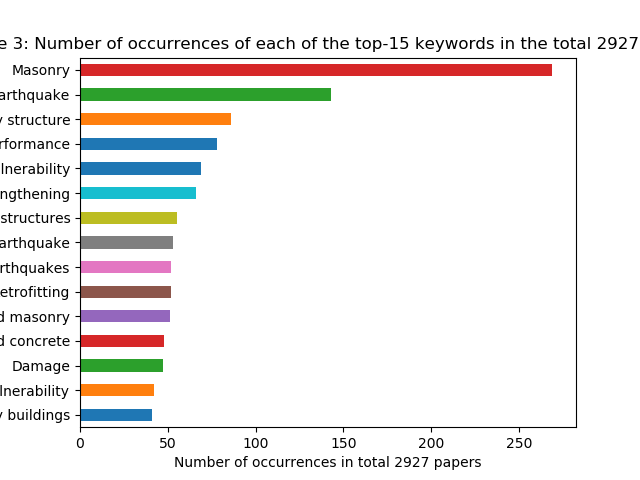

In [15]:
from helperfuncs import word_count

list_of_lists = df["Keywords"].dropna().values
list_of_keywords = [item for sublist in list_of_lists for item in sublist]
keyword_count_dict = word_count(list_of_keywords)
top_keyword_count = pd.Series(keyword_count_dict).sort_values(ascending=False).head(num_kw)

fig04 = plt.figure()
ax04 = fig04.add_subplot(1, 1, 1)
top_keyword_count.iloc[::-1].plot.barh(ax=ax04)
title_fig04 = "Figure 3: Number of occurrences of each of the top-{0} keywords in the total {1} papers".format(num_kw, number_of_papers)
ax04.set_title(title_fig04)
ax04.set_xlabel('Number of occurrences in total {0} papers'.format(number_of_papers))
ax04.tick_params('y', colors='k')

### Time series of the top-{{num_kw}} keywords

<IPython.core.display.Javascript object>


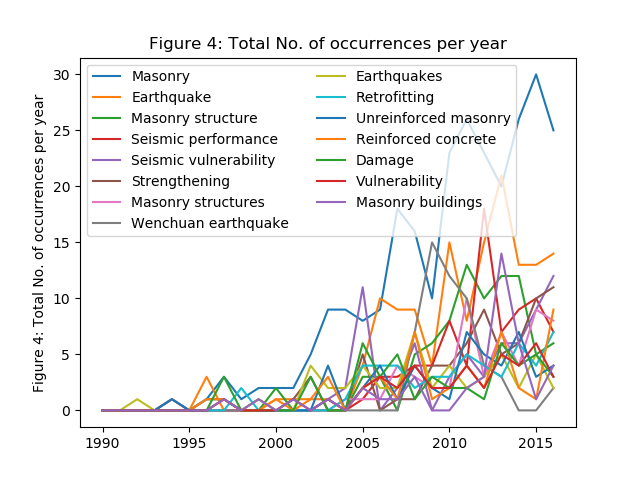

<IPython.core.display.Javascript object>


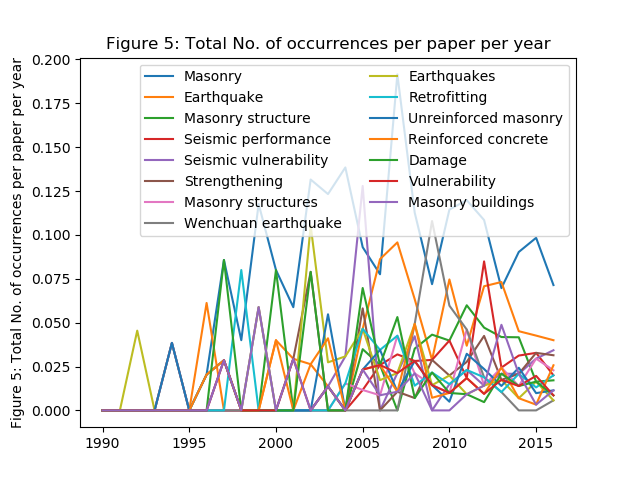

In [16]:
fig05 = plt.figure()
ax05 = fig05.add_subplot(1, 1, 1)

fig06 = plt.figure()
ax06 = fig06.add_subplot(1, 1, 1)

top_keywords = list(word for word in top_keyword_count.index)
occurences_per_year = dict()
occurences_per_year_per_paper = dict()
for keyword in top_keywords:
    count_kw = lambda x: sum(rec.count(keyword) for rec in x.values if isinstance(rec, list))
    occurences_per_year[keyword] = df.groupby("Year")["Keywords"].apply(count_kw)
    occurences_per_year_per_paper[keyword] = occurences_per_year[keyword] / papers_per_year
    ax05.plot(occurences_per_year[keyword])
    ax06.plot(occurences_per_year_per_paper[keyword])

title_fig05 = "Figure 4: Total No. of occurrences per year"
ax05.set_title(title_fig05)
ax05.legend(top_keywords, loc="best", ncol=2)
ax05.set_ylabel(title_fig05)

title_fig06 = "Figure 5: Total No. of occurrences per paper per year"
ax06.set_title(title_fig06)
ax06.legend(top_keywords, loc="best", ncol=2)
ax06.set_ylabel(title_fig06)
ax06.tick_params('y', colors='k')

<IPython.core.display.Javascript object>


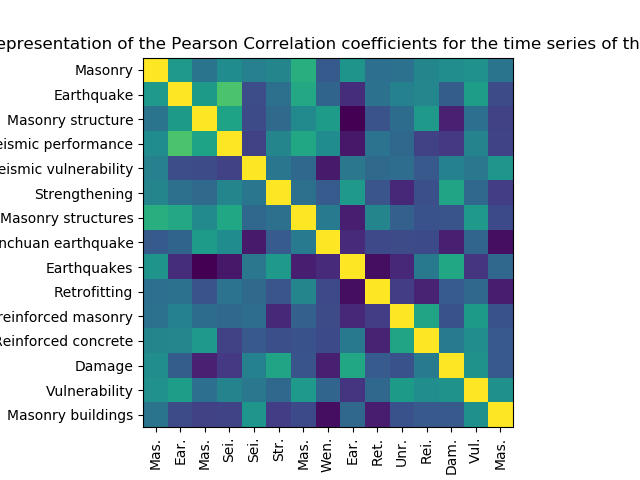

In [17]:
import numpy as np
title_fig07 = "Figure 6: Color representation of the Pearson Correlation coefficients for the time series of the top-{0} keywords".format(num_kw)
obs_matrix = np.array([occurences_per_year_per_paper[kw].values for kw in top_keywords[:num_kw]])
correlation_coefficients = np.corrcoef(obs_matrix)
fig07 = plt.figure()
ax07 = fig07.add_subplot(1, 1, 1)
ax07.imshow(correlation_coefficients)  # , interpolation='nearest')
ax07.set_title(title_fig07)
ax07.set_xticks(range(num_kw))
ax07.set_xticklabels(map(lambda x: x[:3]+".", top_keywords[:num_kw]), rotation='vertical')
ax07.set_yticks(range(num_kw))
ax07.set_yticklabels(top_keywords[:num_kw])
ax07.tick_params('y', colors='k')

In [18]:
# Number of keywords to include in the bibliographic map
num_kw_map = 10

### Co-occurrence matrix for the top-{{num_kw_map}} keywords

<IPython.core.display.Javascript object>


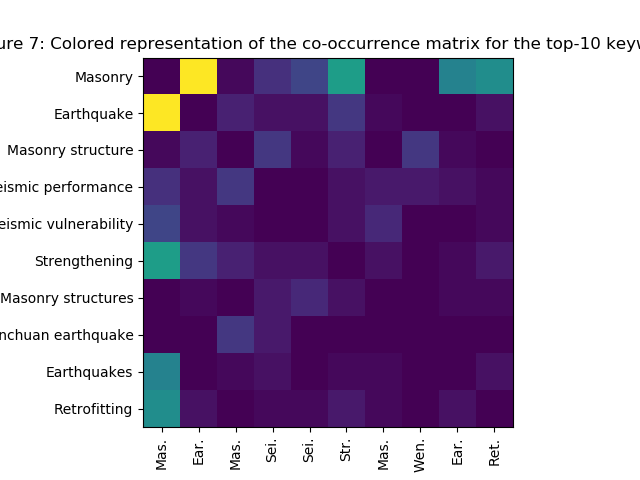

In [19]:
title_fig08 = "Figure 7: Colored representation of the co-occurrence matrix for the top-{0} keywords".format(num_kw_map)
top_keywords[:num_kw] = top_keywords[:num_kw_map]
occurrence_matrix = np.zeros((10, df["Keywords"].dropna().size))
for idx, kw in enumerate(top_keywords[:num_kw]):
    occurrence_matrix[idx, :] = df["Keywords"].dropna().map(lambda x: 1 * (kw in x))
cooccurrence_matrix = occurrence_matrix.dot(occurrence_matrix.T)
np.fill_diagonal(cooccurrence_matrix, 0)
fig08 = plt.figure()
ax08 = fig08.add_subplot(1, 1, 1)
ax08.imshow(cooccurrence_matrix)  # , interpolation='nearest')
ax08.set_title(title_fig08)
ax08.set_xticks(range(num_kw_map))
ax08.set_xticklabels(map(lambda x: x[:3]+".", top_keywords[:num_kw]), rotation='vertical')
ax08.set_yticks(range(num_kw_map))
ax08.set_yticklabels(top_keywords[:num_kw])
ax08.tick_params('y', colors='k')

### Bibliometric maps for the top-{{num_kw_map}} keywords - FIRST DRAFT

**FIX THE FOLLOWING CODE AND TEXT. ADD EXPLANATIONS!!!**

<IPython.core.display.Javascript object>


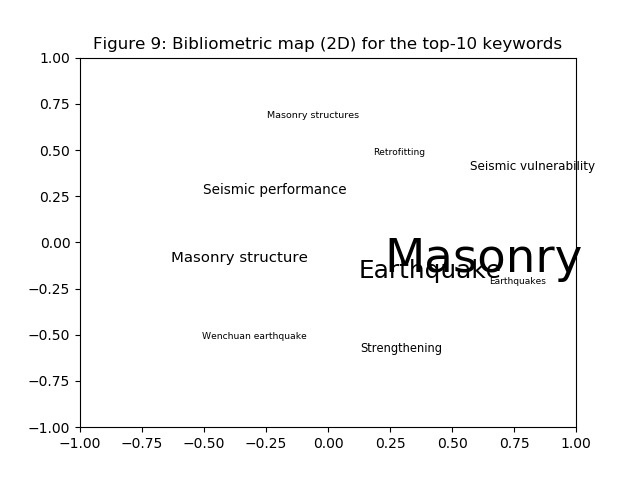

(-1, 1)

In [20]:
from sklearn.manifold import MDS

# Figure 9
title_fig09 = "Figure 9: Bibliometric map (2D) for the top-10 keywords"
dissimilarity = 1 - (cooccurrence_matrix / np.amax(cooccurrence_matrix))
model2D_kw = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out2D_kw = model2D_kw.fit_transform(dissimilarity)
fig09 = plt.figure()
ax09 = fig09.add_subplot(1, 1, 1)
for idx, (x, y) in enumerate(out2D_kw):
    kw = top_keywords[idx]
    count = top_keyword_count[kw]
    ax09.text(x, y, kw, fontsize=count/8, ha='left')
ax09.set_title(title_fig09)
# ax09.autoscale()
# plt.axis('equal')
ax09.set_xlim((-1, 1))
ax09.set_ylim((-1, 1))
# plt.show()

In [2]:
from mpl_toolkits.mplot3d import Axes3D

# Figure 10
title_fig10 = "Figure 10: Bibliometric map (3D) for the top-10 keywords (Drag to rotate)"
model3D_kw = MDS(n_components=3, dissimilarity='precomputed', random_state=1)
out3D_kw = model3D_kw.fit_transform(dissimilarity)
fig10 = plt.figure()
ax10 = fig10.add_subplot(1, 1, 1, projection=Axes3D.name)
for idx, (x, y, z) in enumerate(out3D_kw):
    kw = top_keywords[idx]
    count = top_keyword_count[kw]
    ax10.text(x, y, z, kw, fontsize=count/8, ha='left')
ax10.set_title(title_fig10)
# plt.axis('equal')
ax10.set_xlim((-1, 1))
ax10.set_ylim((-1, 1))
ax10.set_zlim((-1, 1))
# plt.show()

NameError: name 'MDS' is not defined

<IPython.core.display.Javascript object>


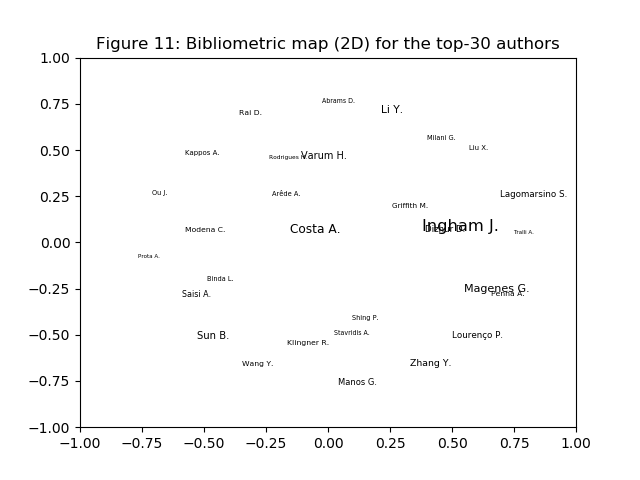

(-1, 1)

In [22]:
nauth = 30  # 10
title_fig11 = "Figure 11: Bibliometric map (2D) for the top-{0} authors".format(nauth)
list_of_authors = [item for sublist in df["Author"].values for item in sublist]
auth_count_dict = word_count(list_of_authors)
top_author_count = pd.Series(auth_count_dict).sort_values(ascending=False).head(nauth)
top_authors = list(top_author_count.index)

occurrence_matrix_auth = np.zeros((nauth, df["Author"].size))
for idx, auth in enumerate(top_authors):
    occurrence_matrix_auth[idx, :] = df["Author"].map(lambda x: 1 * (auth in x))
cooccurrence_matrix_auth = occurrence_matrix_auth.dot(occurrence_matrix_auth.T)
np.fill_diagonal(cooccurrence_matrix_auth, 0)
dissimilarity_auth = 1 - (cooccurrence_matrix_auth / np.amax(cooccurrence_matrix_auth))
model2D_auth = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out2D_auth = model2D_auth.fit_transform(dissimilarity_auth)

fig11 = plt.figure()
ax11 = fig11.add_subplot(1, 1, 1)
for idx, (x, y) in enumerate(out2D_auth):
    auth = top_authors[idx]
    count = top_author_count[auth]
    ax11.text(x, y, auth, fontsize=count/4, ha='left')
ax11.set_title(title_fig11)
# ax11.autoscale()
# plt.axis('equal')
ax11.set_xlim((-1, 1))
ax11.set_ylim((-1, 1))
# plt.show()